

---

# A notebook by Maxime Colignon and Yoach Lacombe

---



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd
import seaborn as sns
import sys
import os
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
#Loading training data
xtrain = pd.read_csv('/content/drive/My Drive/data/challenge/xtrain_challenge.csv', delimiter=',')
ytrain = pd.read_csv('/content/drive/My Drive/data/challenge/ytrain_challenge.csv', delimiter=',')
xtest = pd.read_csv('/content/drive/My Drive/data/challenge/xtest_challenge.csv', delimiter=',')


X_train = xtrain.values
y_train = ytrain.values
y_train = y_train.ravel()
X_challenge = xtest.values



---


# 1. Exploratory Data Analysis


---



In [0]:
xtrain.head()

,qs1,qs2,qs3,qs4,qs5,qs6,qs7,qs8,qs9,qs10,qs11,qs12,qs13,qr1,qr2,qr3,qr4,qr5,qr6,qr7,qr8,qr9,qr10,qr11,qr12,qr13,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11
0,1.0,0.0,0.0,-3.45,-13.14,1.33,0.27,0.99,2.01,212.61,47.40,0.0,0.0,1.0,0.0,0.0,-2.99,-16.61,1.91,0.16,0.81,0.38,177.85,30.02,0.0,0.00,6190.44,6451.89,7382.84,6075.20,10290.42,6839.45,6782.62,7594.45,6711.65,6664.71,6688.64
1,1.0,0.0,0.0,-2.67,-4.88,7.44,0.94,2.03,0.72,271.53,41.95,0.0,0.1,1.0,0.0,0.0,43.33,-22.09,-6.73,3.92,2.38,1.92,194.98,25.12,0.0,0.37,1998.00,2152.79,3329.34,2793.19,2358.42,2454.09,2905.30,2299.96,2434.24,3009.29,2576.67
2,1.0,0.0,0.0,2.46,7.30,-9.13,1.83,1.17,0.19,359.26,58.69,0.0,1.0,1.0,0.0,0.0,-4.50,-23.19,6.68,0.08,0.01,0.42,170.83,61.30,0.0,1.00,2141.67,1632.99,1729.66,1791.57,1913.13,1983.23,1819.05,1816.75,1902.28,2899.05,1795.84
3,1.0,0.0,0.0,17.31,-5.53,-8.82,1.00,1.87,1.15,283.71,53.40,0.0,1.0,1.0,0.0,0.0,1.40,-6.28,1.69,0.85,0.01,0.61,301.23,59.35,1.0,1.00,2400.46,2367.91,2601.43,2535.50,1940.38,2301.36,2215.60,2708.72,2524.65,3274.52,3233.94
4,1.0,0.0,0.0,15.76,7.75,5.65,2.49,1.11,1.56,232.08,25.18,0.0,0.0,1.0,0.0,0.0,-0.71,-13.37,1.12,2.17,0.01,0.90,342.37,48.03,0.0,0.01,1830.43,1715.43,2123.74,2386.98,1028.29,1890.42,2035.30,2013.08,2529.66,2941.38,2288.81


Here are the informations we were given on the data: xtrain and xtest contains one observation per row which contains following entries based on a pair of images:

- columns 1-13 - 13 qualities on first image;
- columns 14-26 - 13 qualities on second image;
- columns 27-37 - 11 matching scores between the two images.

ytrain contains one line with each entry corresponding to one observation in xtrain, maintaining the order, and has '1' if a pair of images belong to the same person and '0' otherwise.

## 1.1 Correlation between features and output

The first step to better understand our data is to see how the different features are correlated to each other and how each feature is correlated to the output. 

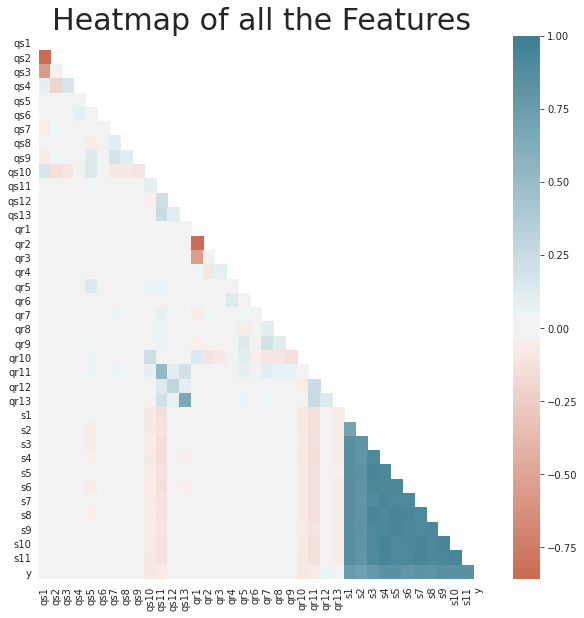

In [0]:
## Plot fig sizing. 
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (10,10))
## Plotting heatmap. 

xtrain_labelled = pd.concat([xtrain,ytrain],axis=1)

# Generate a mask for the upper triangle 
mask = np.zeros_like(xtrain_labelled.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(xtrain_labelled.corr(), cmap=sns.diverging_palette(20, 220, n=200), mask = mask, annot=False, center = 0, );
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 30);

We can see that the matching score s1 to s11 are highly correlated between themselves, and also highly correlated to the output.

We also observe that individual qualities of each image (qr and qs features) are not at all correlated with the output, which isn't surprising since features from a single image cannot indicate similarity with another image. 

We also observe some correlation between some of the qr and qs features, but from this heatmap we cannot yet see clearly how the different qr and qs features are related to each other. 

Let's look at the correlation between features when only considering matched pairs (y=1).

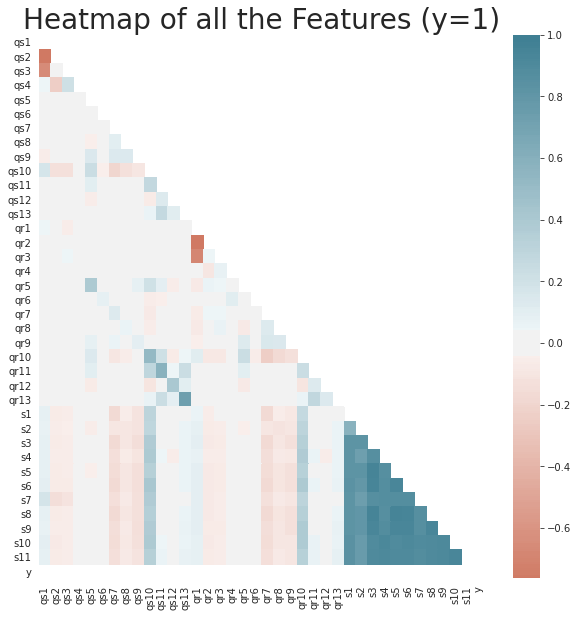

In [0]:
## Plot fig sizing. 
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (10,10))
## Plotting heatmap. 

xtrain_labelled_1 = xtrain_labelled[np.array(ytrain==1)]

# Generate a mask for the upper triangle 
mask = np.zeros_like(xtrain_labelled_1.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(xtrain_labelled_1.corr(), cmap=sns.diverging_palette(20, 220, n=200), mask = mask, annot=False, center = 0, );
## Give title. 
plt.title("Heatmap of all the Features (y=1)", fontsize = 28);

We can clearly see that there is much stronger correlations between qr and qs features for matched pairs. From that observation it is fair to assume that it will play an important role in the prediction of the label. 

## 1.2 Data distribution

To get a better understanding of the data at hand we can explore how it is distributed. 

First, we want to take a look at the qualities of each image. To do this we will concatenate the train set and test set and then look how each qs (qualities of the first image) is distributed compared to each qr (qualities of the second image).

In [0]:
data = pd.concat([xtrain,xtest],axis=0)

No handles with labels found to put in legend.


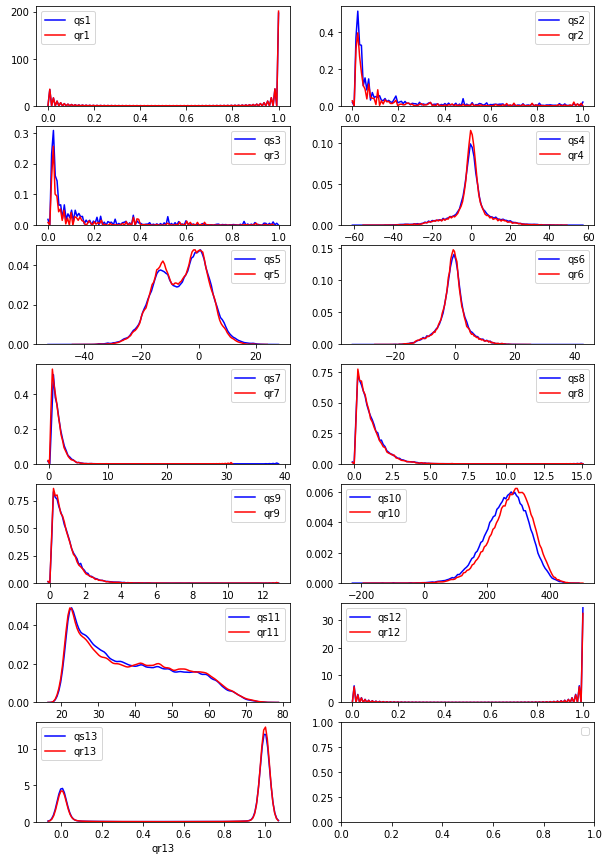

In [0]:
f, axes = plt.subplots(7,2, figsize=(10, 25))
for k in range(13):
  sns.distplot(data.iloc[:,k] , color="blue", ax=axes[k//2,k%2],label="qs"+str(k+1),hist=False)
  sns.distplot(data.iloc[:,13+k], color="red", ax=axes[k//2,k%2],label="qr"+str(k+1),hist=False)
  axes[k//2,k%2].legend()
plt.show()

We observe that qr and qs follow the same distributions, which confirms the assumption that each qr correspond to the same calculation as its corresponding qs. We can thus infer two things :
- The data is symetric with respect to qr/qs, switching qr and qs in a row does not change the information. This is very important and we will take advantage of this symetry later.
- Each image can be uniquely identified by its "q" vector.

Notes on the distributions : 
- 1, 12, 13 are mostly zero or one, with a lot more ones than zeros
- 4, 6 look a lot like Cauchy distributions (high kurtosis), which can model the ratio of two Gaussian distributions with identical means.
- 7,8,9 look a lot like F distributions (high positive skew), which are used to test if the variance of two populations are equal, they thus may be indicator of face symetry (each population being one side of the face for exemple).
- 2, 3 are similar to 7,8,9 but are very noisy. 

For the matching score s1 to s11, it would be especially intersting to see how each is distributed with respect to the value of y. If for a given s feature the distribution of s given y=0 is well separated from the distribution of s given y=1, then the matching score is good at differentiating matching pairs from mismatched pairs.

In [0]:
xtrain_1 = xtrain[np.array(ytrain==1)]
xtrain_0 = xtrain[np.array(ytrain==0)]

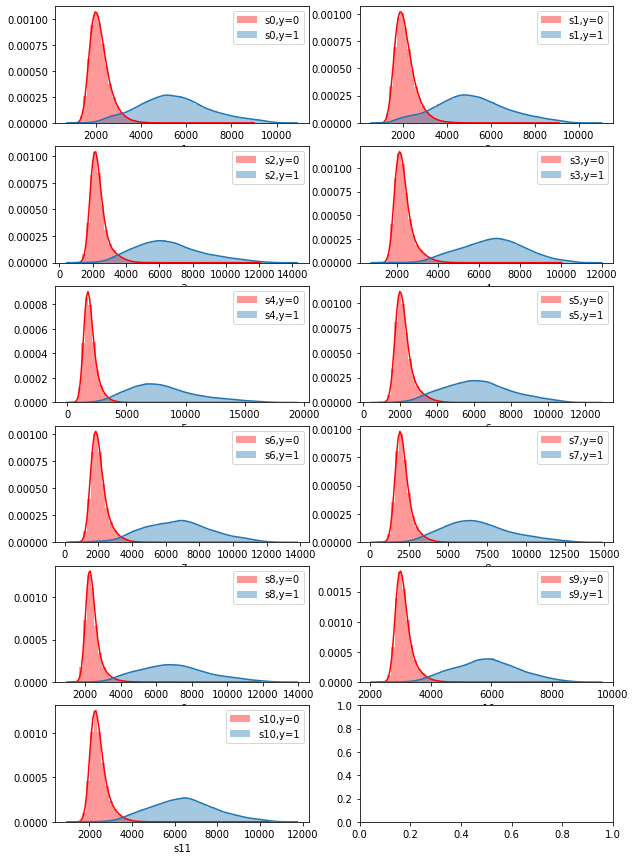

In [0]:
f, axes = plt.subplots(6,2, figsize=(10, 25))
for k in range(11):
  sns.distplot(xtrain_0.iloc[:,k+26] , color="red", ax=axes[k//2,k%2],label="s"+str(k)+",y=0")
  sns.distplot(xtrain_1.iloc[:,k+26], ax=axes[k//2,k%2],label="s"+str(k)+",y=1")
  axes[k//2,k%2].legend()
plt.show()

As we can see the matching scores all follow about the same distribution. As expected, the distrubtion given y=0 is well separated from the distribution given y=1. 

It will not give us much information to plot the qr and qs distributions with respect to y. Independently of each other, qr and qs are not indicators of similarity between images, a difference in the distrubution of a given q feature given y=0 and the distribution given y=1 would only point out a bias in the distribution of image pairs. 

## 1.3 PCA Visualization

Let's do a quick PCA Visualization with 2 components using standard scaling (we will go in depth on scaling methods in part 2.1). We scaled the data with RobustScaler, we will discuss the effects of different scalers in part 2.1

In [0]:
scaler = RobustScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

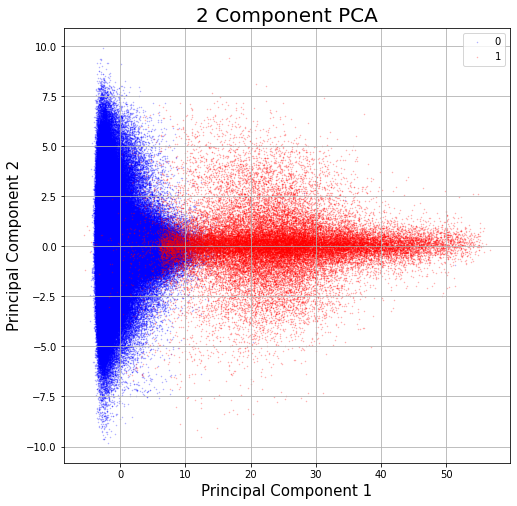

In [0]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(xtrain_scaled)
xtrain_pca_2 = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([xtrain_pca_2, ytrain], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [0,1]
colors = ['b','r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['y'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 1
               , marker = '.'
               , alpha = 0.3)
ax.legend(targets)
ax.grid()

## 1.4 Feature importance

Another interesting indsight is feature importance. It allows us to understand which features play the most important role in discriminating between a matching pair of images and mismatched pair of images. Feature importance is dependant on the classifier used, here we use XGBClassifier which we will discuss in depth in part 3. We ranked features based on gain. A feature has high gain if on average, splitting a node in a tree according to this feature results in a high accuracy gain.

In [0]:
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method = "gpu_hist",
                    scale_pos_weight =2, 
                    n_estimators = 1000, 
                    min_child_weight = 0, 
                    max_depth = 7, 
                    max_delta_step = 0.2, 
                    learning_rate= 0.25, 
                    gamma = 0.0, 
                    colsample_bytree=0.7, 
                    colsample_bynode =1.0, 
                    importance_type = "weight")

xgb.fit(xtrain,ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1.0, colsample_bytree=0.7, gamma=0.0,
              learning_rate=0.25, max_delta_step=0.2, max_depth=7,
              min_child_weight=0, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

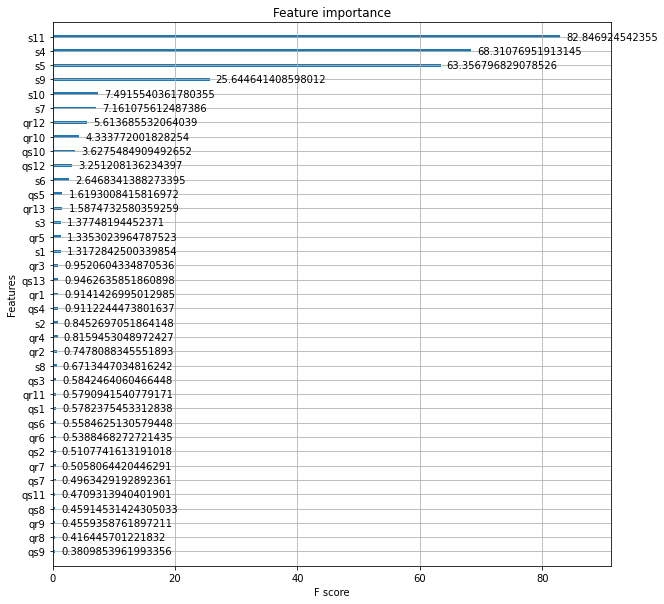

In [0]:
from xgboost import plot_importance

f = plt.figure(figsize=(10,10))
ax = f.add_subplot()
plot_importance(xgb,ax=ax,importance_type='gain')

Here we see something surprising. We would expect to see all matching scores (s1 to s11) score way higher than the individual qualities (qr and qs). We can see this is not the case : s11, s4, s5, s9, s10, s7 are on top, but the other matching scores score lower than some qr and qs features. 

As we saw in 1.1 and 1.2, the information given by the matching score is redundant. Therefore, after comparing a few of them, the classifier considers that it will not gain much information by looking at the other matching scores, and 'decides' to compare some qr/qs instead as it will give additionnal information.  

We also observe that in this ranking each qr is often close to its corresponding qs (qr10 is close to qs10, qr7 is close to qs7 etc...). This can be interpreted by the fact that in itself, a quality of a single image does not give any information on the output, it has to be compared with the same quality if the second image. Thus, a split on let's say qs10 is often followed by a split on qr10, in order to compare the two. 


## 1.5 Image distribution

We know that each row contains two images, each identified by its q vector. We wanted to see if we could get some insights about the data by analyzing how the different images are distributed among the datasets, for example wether some images appear in multiple rows. 

### 1.5.1 Counting distinct images

First step it to know wether or not there are images used in multiple rows. To do that we will use our 'data' dataframe (which is the concatenation of xtrain and xtest), we extract the qs and qr vectors which correspond respectively to image1 and image2 for each row, then we concatenate them along the row axis. The resulting dataframe contains the q vector of every image present in the train and test sets. It has 13 columns (q1 to q13).

To see how many distinct images there are, we just drop the duplicates and look at the number of remaining rows. 

In [0]:
qs_vec = data.iloc[:,0:13]
qs_vec.columns=range(1,14)
qr_vec =  data.iloc[:,13:26]
qr_vec.columns=range(1,14)

images = pd.concat([qs_vec,qr_vec],axis=0)
distinct_images = images.drop_duplicates()

In [0]:
print("Number of total images : ",images.shape[0])
print("Number of distinct images :",distinct_images.shape[0])

Number of total images :  8773600
Number of distinct images : 4400990


### 1.5.2 Image redundancy 

There is about only half as much distinct images as total images, meaning there are images used more than once. Let's see if we can get more precise informations.

We will now trow to see image redundancy between there four subsets of images :
- xtrain - image1
- xtrain - image2
- xtest - image1
- xtest - image2

In [0]:
xtrain_image1 = xtrain.iloc[:,0:13]
xtrain_image1.columns = range(1,14)
xtrain_image2 = xtrain.iloc[:,13:26]
xtrain_image2.columns = range(1,14)
xtest_image1 = xtest.iloc[:,0:13]
xtest_image1.columns = range(1,14)
xtest_image2 = xtest.iloc[:,13:26]
xtest_image2.columns = range(1,14)

xtrain_image1_unique = xtrain_image1.drop_duplicates()
xtrain_image2_unique = xtrain_image2.drop_duplicates()
xtest_image1_unique = xtest_image1.drop_duplicates()
xtest_image2_unique = xtest_image2.drop_duplicates()

In [0]:
L=[xtrain_image1_unique,xtrain_image2_unique,xtest_image1_unique,xtest_image2_unique]

duplicates=pd.DataFrame(index=['xtrain_1','xtrain_2','xtest_1','xtest_2'],columns=['xtrain_1','xtrain_2','xtest_1','xtest_2'])
for i in range(4):
  for j in range(4):
    s1 = L[i].shape[0]+L[j].shape[0]
    mix = pd.concat([L[i],L[j]],axis=0)
    s2 = mix.drop_duplicates().shape[0]
    duplicates.iloc[i,j]=s1-s2
display(duplicates)

,xtrain_1,xtrain_2,xtest_1,xtest_2
xtrain_1,89563,115,0,353
xtrain_2,115,1058920,67,22
xtest_1,0,67,70095,291
xtest_2,353,22,291,3183260


This table shows how many distinct images from one subset are reused in another subset. 

On average :
- in the test set each image1 is compared to 45 image2s
- in the train set each image1 is compared to 11 image2s
Four times more comparisons per image 1 in the test set, but same ratio of mismatched pairs (y=0).

The next table showcases the same study but counting multiplicity of images. It thus shows how many images from one subset (rows of the table) are reused in another subset (columns of the table), counting multiplicity in the second subset. 




In [0]:
X_train = xtrain.values
X_challenge  = xtest.values

In [0]:
u_train_1, indices_train_1, counts_train_1 = np.unique(X_train[:, 0:13], axis = 0, return_inverse=True, return_counts = True)
u_train_2, indices_train_2, counts_train_2 = np.unique(X_train[:, 13:26], axis = 0, return_inverse=True, return_counts = True) 
u_test_1, indices_test_1, counts_test_1 = np.unique(X_challenge[:, 0:13], axis = 0, return_inverse=True, return_counts = True)
u_test_2, indices_test_2, counts_test_2 = np.unique(X_challenge[:, 13:26], axis = 0, return_inverse=True, return_counts = True)

def multidim_intersect(arr1, arr2):
    arr1_view = arr1.view([('',arr1.dtype)]*arr1.shape[1])
    arr2_view = arr2.view([('',arr2.dtype)]*arr2.shape[1])
    intersected, indices1, indices2 = np.intersect1d(arr1_view, arr2_view, assume_unique = True, return_indices = True)
    return intersected.view(arr1.dtype).reshape(-1, arr1.shape[1]), indices1, indices2

L=[u_train_1,u_train_2,u_test_1,u_test_2]
indices = [indices_train_1,indices_train_2,indices_test_1,indices_test_2]
counts = [counts_train_1,counts_train_2,counts_test_1,counts_test_2]  
duplicates=pd.DataFrame(index=['xtrain_1','xtrain_2','xtest_1','xtest_2'],columns=['xtrain_1','xtrain2','xtest_1','xtest_2'])
for i in range(4):
  for j in range(i+1):
    _, indices1, indices2 = multidim_intersect(L[i], L[j])
    s1 = sum([counts[i][indi] for indi in indices1])
    s2 = sum([counts[j][indi] for indi in indices2])

    duplicates.iloc[i,j] =s1
    duplicates.iloc[j,i] =s2    
display(duplicates)


,xtrain_1,xtrain2,xtest_1,xtest_2
xtrain_1,1068504,2656,0,8297
xtrain_2,118,1068504,67,22
xtest_1,0,6409,3318296,30742
xtest_2,363,22,298,3318296


Compared to the total number of images, images from one subset is rarely reused in another even when taking the multiplicity into account. Thus, it is probably useless to try to keep track of distinct images. 

## 1.6 Label distribution

In [0]:
print("Percentage of rows labelled 0 : " + str(100*sum(y_train == 0)/len(y_train)))

Percentage of rows labelled 0 : 0.9629453890673315


**Observation :** The dataset is unbalanced as we could have guess. Most of the comparison compare two different faces. In practice, we will take that in consideration to choose and tune the classifier we will use.
We can also draw some interesting comparisons with the task of detecting fraud (which are rare event just like detecting the same face). However, we dismissed this lead to the benefit of more profitable outcomes. 

## 1.7 Conclusion 
In this section, we draw some important observations which we summarize hereafter :
- The qualities on each image alone is not enough to differentiate faces.
- The matching score are very good at discriminating zeros and ones, but the qr/qs features give additionnal information to discriminate edges cases.
- The dataset is unbalanced. An imbalanced dataset need some precaution to be well classified.


---


# 2 Preprocessing


---


In this section, we will focus on deciding either we should transform the dataset before classifying.





## 2.1 Scalers

### Standard Scaling

Standard Scaling performs mean removal and variance scaling. It is useful in some algorithm such as SVM or KNN which rely on a distance measure in a the feature space. Depending on the algorithm used, it can help speed up processing or improve accuracy. **However**, we will not use standard scaling for 2 reasons :
- tree-based methods gain little benefit from standard scaling : they are impermeable to monotic transformation since it only needs to choose cut points
- Standard scaling is very vulnerable to outliers (extreme and rare values) which exist on the dataset. We want to keep these outliers because it is often the sign of two similar images.

### Robust Scaling

The last point motivates the use of a robust scaling. It uses an interquantile range instead of using mean and variance as before. This allows outliers to remain outliers after the scaling. 

### PowerTransformer
PowerTransformer applies a power transformation to each feature to make the data more Gaussian-like. As we have observed in part 1.2, some of q features are highly positively skewed (especially qr/qs 7,8,9). We are interested in this transformation because it 'regularizes' the distribution of features and might make it easier for tree-based method to choose good cut-points efficiently. 

To visualize the effect on these transformations on a simpler case, see https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html


Hereafter, we visualize the effect of such transformations on some of the q features. The matching scores distributions are already close to gaussians they are not much transformed by the power transformer.

In [0]:
xtrain_labelled = xtrain.copy()
xtrain_labelled["Y"] = y_train

In [0]:
scaler = StandardScaler()
xtrain_standard = scaler.fit_transform(X_train)
xtrain_labelled_standard = pd.concat([pd.DataFrame(xtrain_standard),ytrain],axis=1)
xtrain_labelled_standard.columns = xtrain_labelled.columns

scaler = RobustScaler()
xtrain_robust = scaler.fit_transform(X_train)
xtrain_labelled_robust = pd.concat([pd.DataFrame(xtrain_robust),ytrain],axis=1)
xtrain_labelled_robust.columns = xtrain_labelled.columns

scaler = PowerTransformer(method = 'yeo-johnson')
xtrain_pt = scaler.fit_transform(X_train)
xtrain_labelled_pt = pd.concat([pd.DataFrame(xtrain_pt),ytrain],axis=1)
xtrain_labelled_pt.columns = xtrain_labelled.columns

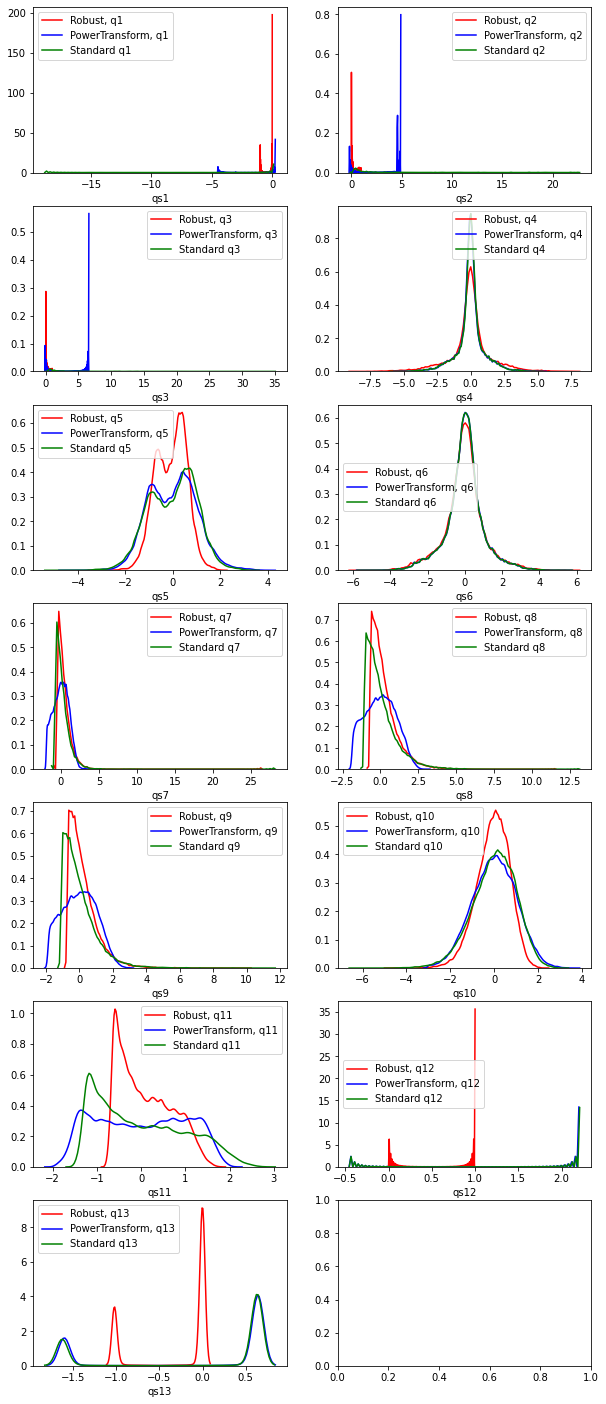

In [0]:
f, axes = plt.subplots(7,2, figsize=(10, 25))
for i,k in enumerate(range(13)):
  axes[i//2,i%2].set_title("q"+str(k+1))
  sns.distplot(xtrain_labelled_robust.iloc[:,k] , color="red", ax=axes[i//2,i%2],label="Robust, q"+str(k+1),hist=False)
  #sns.distplot(xtrain_labelled_robust.iloc[:,13+k], color="darkred", ax=axes[i//2,i%2],label="Robust, qr"+str(k+1),hist=False)


  sns.distplot(xtrain_labelled_pt.iloc[:,k] , color="blue", ax=axes[i//2,i%2],label="PowerTransform, q"+str(k+1),hist=False)
  #sns.distplot(xtrain_labelled_pt.iloc[:,13+k], color="darkblue", ax=axes[i//2,i%2],label="PowerTransform, qr"+str(k+1),hist=False)

  sns.distplot(xtrain_labelled_standard.iloc[:,k] , color="green", ax=axes[i//2,i%2],label="Standard q"+str(k+1),hist=False)
  #sns.distplot(xtrain_labelled_standard.iloc[:,13+k], color="darkgreen", ax=axes[i//2,i%2],label="Standard qr"+str(k+1),hist=False)
  axes[i//2,i%2].legend()
plt.show()

[]

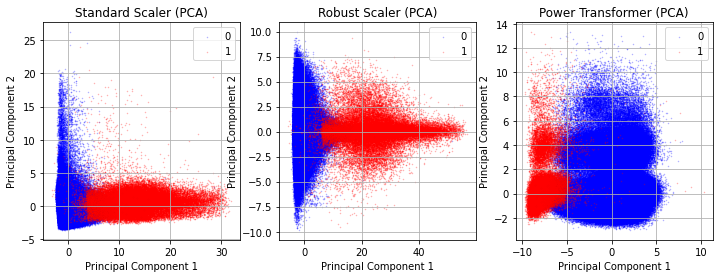

In [0]:
fig, ax = plt.subplots(1,3,figsize = (12,4))

ax[0].set_title('Standard Scaler (PCA)', fontsize = 12)
ax[1].set_title('Robust Scaler (PCA)', fontsize = 12)
ax[2].set_title('Power Transformer (PCA)', fontsize = 12)

S = [xtrain_standard,xtrain_robust,xtrain_pt]

for k in range(3):
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(S[k])
  xtrain_pca_2 = pd.DataFrame(data = principalComponents,
                            columns = ['principal component 1', 'principal component 2'])
  finalDf = pd.concat([xtrain_pca_2, ytrain], axis = 1)
  ax[k].set_xlabel('Principal Component 1', fontsize = 10)
  ax[k].set_ylabel('Principal Component 2', fontsize = 10)
  targets = [0,1]
  colors = ['b','r']
  for target, color in zip(targets,colors):
      indicesToKeep = finalDf['y'] == target
      ax[k].scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                , finalDf.loc[indicesToKeep, 'principal component 2']
                , c = color
                , s = 1
                , marker = '.'
                , alpha = 0.3)
      
  ax[k].legend(targets)
  ax[k].grid()
plt.plot()

## 2.2 Effect of scaling on prediction scores

On our quest to scoring, we had to glean any slight improvments in terms of accuracy. Using PowerTransformer rapidly proved to be the right way to maximize the score.

Here some examples of the score according to the method of transformation.

In the following, we only use XGBClassifier, the python API of the xgboost method which uses gradient boosting. We go more in depth about XGBoost later on.


For the next results, we used as parameters :
  > `(learning_rate= 0.1,n_estimators=1000, min_child_weight=3, max_depth=9, max_delta_step=0, gamma=0.1, colsample_bytree=0.9)`

| Transformation used | Score |  Relative improvement |
|------|------|------|
|   Without transformation  | 0.9985619125 | 0% |
|   StandardScaler  | 0.998517914014 | -0.0044% | 
|   PowerTransformer  | 0.998583007664 | 0.0021% |

  > `(tree_method = "gpu_hist",scale_pos_weight =2,  n_estimators = 1000, min_child_weight = 0, max_depth = 7, max_delta_step = 0.2, learning_rate= 0.25, gamma = 0.0, colsample_bytree=0.7, colsample_bynode =1.0, importance_type = "weight") - We also used a preprocessing method we will delve into later (Symmetrisation).`


| Transformation used | Score |  Relative improvement |
|------|------|------|
|   Without transformation  | 0.998607116424 | 0% |
|   RobustScaler  | 0.998618568084 | 0.0011% | 
|   PowerTransform  | 0.998638457811 | 0.0031% |


## 2.3 Conclusion
A simple transformation allows to perform better results : PowerTransform.



---


# 3 Model Selection and Parameter Tuning


---



## 3.1 A quick overview of the models examined during our research

Before focusing on XGBoost, here a list of all the models we tried and/or dismissed, their results and features.
- SVM and KNN : it quickly goes slower as the number of features and rows grows. We dismissed it right away.
- A fraud detection approach : Use clustering with 1 center (supposed to be the the center of the 0 labels), and compute distance to this cluster. Decide a threshold on this distance. This method yields relatively good results (0.997) and is fast. However it is nothing as efficient as XGB or even RandomForestClassifier.
- Neural Network (using TensorFlow and Keras) : Difficult tuning, we could not avoid overfitting. Moreover it ended up difficult to deal with the slowness of fitting.
- Bagging with KNearestClassifier, it was promising :0.995 on some cases using only 10k rows. But extending it to the whole train set resulted in very slow computation and little improvement on accuracy. 
- RandomForestClassifier, one of the most serious candidate : This classifier yields good results even with a low number of trees (0.9980 with n_estimators = 100). However it is really slow compared to gradient boosting methods due to the large number of data.




## 3.2 The efficiency of ensemble methods

Ensemble methods are based on a simple motto : computes a large number of weak classifiers in order to achieve high classification (a kind of wisdom of the crowd). RandomForestClassifier, Bagging, XGBoostClassifier are three ensemble methods, each with its specificity.
Why is it so efficient ? Maybe because it is faster, thanks to being parallelized. Or because it mostly avoids overfitting, uses feature selection and can produce a classifier that would not be possible with a single model.

## 3.3 The choice of XGBoost

Of all the methods we tried, stochastic gradient boosting methods such as lightgbm or xgboost (extreme gradient boosting) performed the best results in a extremely short amount of time.
Here a simplified overview on how it work :
- Contrarily to Bagging or Forest, gradient boosting consists on trying to adapt the new weak classifier thanks to the results of the old weak classifiers. In doing so, the new classifier will concentrate on wrong classification. Moreover, because it uses the result of all the classifier to decide the classification, it will avoid overfitting in most case. The new classifier is modeled in order to minimize a global loss by gradient descent.
- XGB achieve such good results by, among others, using a loss function with a specific regularization terms, approximating gradient and finally proposing a large number of hyperparameters to tune the classifier (for example the number of features it uses by tree).


## 3.3 XGBoost and GPU

From the beginning, XGBoost performed top scores. However tuning parameters became more and more difficult as the number of trees grew due to the increase in computation time). 
With the following parameters, the training time was 55 minutes. 
> `learning_rate= 0.1,n_estimators=1000, min_child_weight=3, max_depth=9, max_delta_step=0, gamma=0.1, colsample_bytree=0.9`

However, this computation time can be reduce to no more than 3 minutes thanks to a few tricks.

Firstly, XGB allows to use histogram in order to make splitting faster which makes computation more than 8x faster. This trick comes with a little lower accuracy, though (-0.0049% for the last parameters).
Secondly, XGB is GPU-compatible.

Thus, thanks to free GPU in Google Colab and in Kaggle notebook, we performed a faster and more efficient XGBoost tuning than our fist trial-and-error approach.  




## 3.4 XGBoost Tuning



XGBoost classifier is highly dependent on parameter tuning to produce good results. With default parameters, the test accuracy was bellow 99.80% but with fine-tuned parameters we reached 99.859%.

In order to fine tune the hyper-parameters, we first used GridSearchCV but then moved on the RandomizedSearchCV which is more time efficient. GridSearchCV tests all the hyper-parameters combinations in the grid, thus returning the best combination but takes a lot of time to compute. On the other hand, RandomizedSearchCV randomly selects a fixed numer (n_iter) of hyper-parameters combinations yielding a 'good-enough' set of parameters in a relatively short amount of time.

The next chunk of code shows an exemple of how we ran the cross-validations. 

In [0]:
#Just an example of one of our grid search
param_grid = [{'n_estimators':[1000],
               'max_depth': [6,7,8,9,10],
               'min_child_weight':[2,3,4]
               'eta': [0.01,0.1],
               'max_delta_step': [0,0.1],
               'gamma':[0.01,0.1,1],
               'colsample_bytree' : [0.8,0.9,1],
               'lambda' : [1]}]

cv = RandomizedSearchCV(estimator=XGBClassifier(), 
                        n_iter=100,
                        param_grid=param_grid, 
                        scoring='accuracy')

cv.fit(xtrain, ytrain)  
cv_results = pd.DataFrame(gscv.cv_results_)
cv_results.head()

In order to best tune the model, we decided to perform a few random grid search each one of them being more and more specific.
Here an example of one of our results : 

In [3]:
grid = pd.read_csv("out_xgb_precis.csv") 
grid.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scale_pos_weight,param_objective,param_n_estimators,param_min_child_weight,param_max_depth,param_max_delta_step,param_learning_rate,param_importance_type,params,split0_test_balanced_accuracy,split1_test_balanced_accuracy,split2_test_balanced_accuracy,split3_test_balanced_accuracy,split4_test_balanced_accuracy,split5_test_balanced_accuracy,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,split5_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,15.752524,0.419058,3.708344,0.124022,1,binary:logistic,960,2,6,0.1,0.00,cover,"{'scale_pos_weight': 1, 'objective': 'binary:l...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,44,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49,0.962944,0.962944,0.962944,0.962944,0.962944,0.962950,0.962945,0.000002,44
1,20.113369,0.370364,6.934799,0.213154,1,binary:logistic,1000,0,6,0.1,0.10,cover,"{'scale_pos_weight': 1, 'objective': 'binary:l...",0.988200,0.988326,0.990039,0.990438,0.990240,0.988849,0.989349,0.000920,35,0.981055,0.982403,0.983435,0.984344,0.984861,0.982793,0.983148,0.001259,35,0.998602,0.998703,0.998776,0.998843,0.998883,0.998731,0.998756,0.000092,35
2,28.475249,0.543904,10.355014,0.392220,1,binary:logistic,1010,2,8,0.0,0.10,weight,"{'scale_pos_weight': 1, 'objective': 'binary:l...",0.990470,0.991251,0.992242,0.992639,0.992446,0.991562,0.991769,0.000757,14,0.985168,0.986539,0.987690,0.988525,0.989197,0.987070,0.987365,0.001317,6,0.998905,0.999006,0.999090,0.999152,0.999203,0.999045,0.999067,0.000097,5
3,15.429256,1.274373,3.254199,1.400390,1,binary:hinge,985,0,6,0.3,0.35,weight,"{'scale_pos_weight': 1, 'objective': 'binary:h...",0.989325,0.983424,0.990223,0.991776,0.985012,0.989394,0.988192,0.002959,38,0.981918,0.977938,0.982547,0.985059,0.979504,0.981843,0.981468,0.002263,36,0.998664,0.998383,0.998708,0.998894,0.998495,0.998658,0.998634,0.000162,36
4,39.793805,0.827331,18.994986,0.174736,1,binary:logistic,1040,0,8,0.2,0.25,cover,"{'scale_pos_weight': 1, 'objective': 'binary:l...",0.990261,0.990975,0.991890,0.992720,0.992353,0.991574,0.991629,0.000825,20,0.985386,0.986906,0.987981,0.988752,0.988668,0.987371,0.987511,0.001155,2,0.998922,0.999034,0.999113,0.999169,0.999163,0.999068,0.999078,0.000085,2


## 3.5 Parameter analysis

Here is a small analysis of some of our optimal parameters :
- tree_method = "gpu_hist" : Using the splitting method discussed earlier with GPU.
- scale_pos_weight = 2 : A parameter to be used in case of unbalanced dataset. Sets a higher weight on the gradient of positive labels. The litterature proposes a value of count(negative examples)/count(Positive examples). However the latter seems to give a too important value to positive label and runs bad result. 
- n_estimators = 1000 : the number of trees. A too high value results to overfitting. 1000 seems to be the best values according to the other parameters.
- max_depth = 7 : the maximum depth of each trees. Can lead to overfitting.
- colsample_bytree = 0.7 : the fraction of features in each tree.
- importance_type = "weight" : Sets how the importance of each feature is decided. "weight" means this number is decided thanks to the number of times each feature is used in splitting.





---


# 4 Going further : Data augmentation 

---



## 4.1 Our next challenge

We now have a model that yields excellent results by himself. However, it appears more and more difficult to achieve better results by parameter tuning. It seemed to be a ceiling which we could not reach. Moreover, our progression on score was less and less visible.
It appears clear that if we wanted improvment, we should concentrate on something else than parameter tuning.

Machine Learning - more especially classification- consists on feeding data to a model in order to predict outcome on new data.
So the only thing we could work on was the dataset.

On the internet, we read a lot about data generation with GAN (neural networks which produces data in order to improve itself). However, using GAN seemed difficult and not worth the effort.

Moreover, it seems difficult to combine images we already have since we don't know how to compute the marching score.

Therefore, we came out with two ideas that both produces a huge improvment. The two ideas are based on data enrichment.



## 4.2 Taking advantage of the symmetry in the data

The next method is specific to the task performed. We used the analysis made in section 1, especially in section 1.2 : Data distribution. 

There is a symmetry in the fact that we compared two images in each row. But the models we used are "unaware" of that fact. So even if a given row "image1-image2-matchingscore" conveys the same information than "image2-image1-matchingscore", the models won't recognize it.

Hence the simple idea to add rows "image2-image1-matchingscore" to the trainset.



On the following, we only show the task on the regular dataset.

In [0]:
def transform_train(x,y):
  '''Returns symmetrized dataset '''
  image1 = x[:,0:13]
  image2 = x[:,13:26]
  commun = x[:,26:]
  symetric = np.c_[image2,image1,commun]
  return np.r_[x,symetric], np.r_[y,y]

In [0]:

print("------Fit--------")
bst = xgb.XGBClassifier(tree_method = "gpu_hist",scale_pos_weight =2,  n_estimators = 1000, min_child_weight = 0, max_depth = 7, max_delta_step = 0.2, 
                              learning_rate= 0.25, gamma = 0.0, colsample_bytree=0.7, colsample_bynode =1.0, 
                              importance_type = "weight") 
bst.fit(X_train, y_train)

print("------Predict--------")
# Classify the provided test data
ytest = bst.predict(y_train)
#np.savetxt('ytest_symmetric.csv', ytest, fmt = '%1.0d', delimiter=',')

It directly yields better results :


  

> `tree_method = "gpu_hist",scale_pos_weight =2,  n_estimators = 1000, min_child_weight = 0, max_depth = 7, max_delta_step = 0.2, learning_rate= 0.25, gamma = 0.0, colsample_bytree=0.7, colsample_bynode =1.0, importance_type = "weight"`





| Transformation | Symmetrisation  | Score |  Relative improvement |
|------|------|------|------|
|   PowerTransformer |False| 0.9985619125 | 0% |
|   None  |True| 0.998607116424 | 0.0045% |
|   PowerTransformer |True| 0.998638457811 | 0.0077% |


## 4.3 Label Propagation

We now have a pretty efficient classifier, and we wanted to know if there was a way to evaluate how confident our classifier is about each predicted label. 

If there is part of the test data for wich our classifier is a 100% confident to have predicted correctly, we could consider that data as correctly labeled and use it to augment our train set. More train data will then yields better accuracy.

To do this, we used the method `predict_probabilites` of `XGBoostClassifier` which returns an array of probabilities. This array contains, for each row of the test set, the probabilty that this row was correctly classified. We observe that the vast majority of the test data was well classified with probability 1, there is only a small subset of less than 20000 rows for which the probability is between 0.99 and 0.5.
> Here is a plot of the probability of being 0 or 1, after prediction of a fitted XGBoost classifier.

>![Probability of the challenge dataset on a XGB model](https://imagizer.imageshack.com/img922/5683/ZSCwbZ.png)

Then, we put the almost-surely labelled data from the test set and combine it with the original train set to form a new, augmented train set than now contains about 4 million unique rows (8 million when we apply symmetrization). Next, we re-train our model on this new train set, and use it try to improve our prediction on the test data that our initial classifier was not very sure about. 

We can then iterate this process as much as desired.

We implemented this method through the `label_propagation` function in the next cell. 

What we refer as the probability threshold e is what determines what we consider an almost_surely labelled row. For example, if e = 0.01, then we consider a row as almost-surely labeled if it is well labeled with probabily > 0.99.

In [0]:
import time

def label_propagation(clf_list,xx,yy,xxtest, e = 0.01, transform_operator = None, symmetricBool = False):
  ''' clf_list : list of classifier used for iterative method
  e : probability threshold'''

  time0 = time.time()
  indicator = 0

  #SYMETRISATION
  if symmetricBool:
    xtrain,ytrain = transform_train(xx,yy)
  else:
    xtrain = xx.copy()
    ytrain = yy.copy()

  xtest = xxtest.copy()


  #TRANSFORMATION
  if transform_operator is not None:
    transform_operator.fit(xtrain)
    xtrain = transform_operator.transform(xtrain)
    xtest = transform_operator.transform(xtest)
    print("----------TRANSFORMATION_DONE---------")

  

  print("TIME ON PREPROCESSING : " + str(time.time() - time0))
  print("Training clf1")
  clf_list[0].fit(xtrain,ytrain)
    
  print("Predicting labels for xtest with clf1")
  ytest = clf_list[0].predict(xtest)
    
  print("Process")
  #Computing probability of being either 0 or 1 for each data point in xtest according to clf1
  y_proba = clf_list[0].predict_proba(xtest)
  y_proba = y_proba[:,1]


  y_test_list = []
  not_in_list = []

  for index_clf in range(1,len(clf_list)):
    time_step = time.time()
    print("------STEP " + str(index_clf)+"--------")

    index_y_proba_sorted = np.argsort(y_proba)
    y_proba_sorted = y_proba[index_y_proba_sorted]

    #Selecting label that are almost surely correct based on probabilities 
    ones_index = np.where(y_proba>(1-e))[0]
    zeros_index = np.where(y_proba<e)[0]
    y_sure_index = np.r_[ones_index,zeros_index]
    y_sure = ytest[np.sort(y_sure_index)]
    x_sure = xtest[np.sort(y_sure_index),:]

    indicator += len(y_sure)
    print("Size of sure labels : " + str(len(y_sure)))
    print("Pourcentage of testset added for now : " + str(indicator/(xxtest.shape[0])))



    #Applying symetrisation if asked
    if symmetricBool:
      x_sure,y_sure = transform_train(x_sure,y_sure)

    #Concatenating the train data with the data almost surely labeled into xtrain2 and ytrain2
    xtrain2 = np.r_[xtrain,x_sure]
    ytrain2 = np.r_[ytrain,y_sure]

    #Keeping track of the index that were not added in the new trainset - small computation astuce
    notin_index = []
    sort_i = np.sort(y_sure_index)
    j_sort = sort_i[0]
    j = 0
    for i in range(xtest.shape[0]):
      if i < j_sort:
        notin_index.append(i)
      if i == j_sort and j < len(sort_i) - 1:
        j_sort = sort_i[j+1]
        j += 1
      if i >j_sort:
        notin_index.append(i)

    #updating xtest
    xtest2 = xtest[np.array(notin_index),:]
    
    print("Fit on the rest")
    #Predicting the remaining data using clf2
    clf_list[index_clf].fit(xtrain2,ytrain2)

    y_test_list = y_test_list + [ytest]
    not_in_list = not_in_list + [notin_index]

    print("Predict on the rest")
    ytest = clf_list[index_clf].predict(xtest2)
    y_proba = clf_list[index_clf].predict_proba(xtest2)

    #Updating variables
    y_proba = y_proba[:,1]
    xtrain = xtrain2
    xtest = xtest2
    ytrain = ytrain2
    e = 0.05

    print("TIME ON STEP " + str(index_clf) + " : " + str(time.time() - time_step))
  
  y_test_list = y_test_list + [ytest]

  print("On reconstitue")
  for i in range(len(not_in_list)-1,-1,-1):
    print("Etape " + str(i))
    y_test_test = y_test_list[i].copy()

    for j in range(0,len(not_in_list[i])):
      y_test_list[i][not_in_list[i][j]] = y_test_list[i+1][j]
    print("Did this step modified some label ? " + str(any(y_test_test !=  y_test_list[i])))


  print("TIME ON THE ALL OPERATION : " + str(time.time() - time0))
  return y_test_list[0]
    


In [0]:
list_clf = [xgb.XGBClassifier(tree_method = "gpu_hist",scale_pos_weight =2,  n_estimators = 1000, min_child_weight = 0, max_depth = 7, max_delta_step = 0.2, 
                              learning_rate= 0.25, gamma = 0.0, colsample_bytree=0.7, colsample_bynode =1.0, 
                              importance_type = "weight") 
for i in range(4)]

y_test = label_propagation(list_clf ,X_train,y_train,X_challenge,e=0.01, transform_operator= PowerTransformer(method='yeo-johnson', standardize=True), symmetricBool=True)

#np.savetxt('ytest_challenge_recursive_3_sym.csv', y_test, fmt = '%1.0d', delimiter=',')

----------TRANSFORMATION_DONE---------
TIME ON PREPROCESSING : 182.52422404289246
Training clf1
Predicting labels for xtest with clf1
Process
------STEP 1--------
Size of sure labels : 3304435
Pourcentage of testset added for now : 0.9958228560682953
Fit on the rest
Predict on the rest
TIME ON STEP 1 : 165.0306053161621
------STEP 2--------
Size of sure labels : 8035
Pourcentage of testset added for now : 0.9982442795941049
Fit on the rest
Predict on the rest
TIME ON STEP 2 : 169.49725437164307
------STEP 3--------
Size of sure labels : 1363
Pourcentage of testset added for now : 0.9986550325829884
Fit on the rest
Predict on the rest
TIME ON STEP 3 : 165.2919909954071
On reconstitue
Etape 2
Did this step modified some label ? True
Etape 1
Did this step modified some label ? True
Etape 0
Did this step modified some label ? True
TIME ON THE ALL OPERATION : 743.9797575473785


Total time with symmetrisation and PowerTransformartion : **12 minutes.**


**Without symmetrisation (with our optimal parameters)**

| Transformation | Symmetrisation |First and next threshold| Number of iteration  | Score |  Relative improvement |
|------|------|------|------|------|------|
|   PowerTransformation  |False|None|0| 0.9985619125 | 0% |
|   PowerTransformation  |False|0.01 then 0.1|2| 0.998733084692 | 0.01714% |
|   PowerTransformation  |False|0.01 then 0.1|3| `0.998743330914` | `0.01816` |
|   PowerTransformation  |False|0.01 then 0.1|4| 0.99872826294 | 0.01666% |
**Note :** We gain a factor 10 in the improvement of the score.

**With symmetrisation (with our optimal parameters)**

| Transformation | Symmetrisation |First and next threshold| Number of iteration  | Score |  Relative improvement |
|------|------|------|------|------|------|
|   PowerTransformation  |False|None|0| 0.9985619125 | 0% |
|   PowerTransformation  |True|0.01 then 0.1|3| 0.998818068069 | 0.0257% |
|   PowerTransformation  |True|0.01 then 0.05|2| 0.998785521243 | 0.0224% |
|   PowerTransformation  |True|0.01 then 0.05|3| `0.998837355076` | `0.0276` |
|   PowerTransformation  |True|0.01 then 0.05|4| 0.99879998649 | 0.02384% |
|   PowerTransformation  |True|0.01 then 0.01|4| 0.998796370185 | 0.0235% |
|   PowerTransformation  |True|0.05|3|0.998808424565| 0.0247% |

>*Little aside on the chose of the probability threshold :* Setting the threshold is a tricky step. It should be high enough to enhance the trainset but small enough to minimize the classification errors on the trainset. An indicator that seems interesting is looking at the percentage of the challengeset that has been added to the trainset. If this percentage is bigger than the actual accuracy of the task, it means that we train our final classifier on a dataset with mislabeled rows. Thus the threshold should be lower.

>For example, with 3 iterations, when we set the threshold to 0.01 then to 0.1, 99,91% if the testset is added to the trainset at the last iteration. It is more than the accuracy of the classifier (99.88%). Moreover, a large threshold means being more permissive in the data we add, and thus adding more mislabelled data.

> However with a threshold of 0.01 then 0.05, this percentage is 99,86% less than the actual accuracy. It does not mean that all of the data added is correctly labeled but it reassures us.




# 5 Conclusion

At first, we mostly focused on finding good parameters for XGBoost which cost us many hours for little results. Then we decided we were done running grid search all night long so we tried to come up with clever techniques to improve our score. We tried feature engineering, by adding distances between qr features and qs features, along with some similarity functions between qr and qs vectors (like cosine similarity), but it did not result in any significant improvement so we eventually gave it up. 

After that, we focused on the idea that if we found a way to be sure about some of the predicted labels we could augment our train set. By exploring the XGBoost API we found the predict_proba function and noticed the vast majority of the test data was well predicted with probability 1. Applying this technique gave us a major accuracy boost, but eventually we lost our 1st place and we knew we had to come up with some new ideas. 

At this point we started exploring the data and tried to really understand it. After exploring a few leads, we finally realized we could take advantage of the symetry between the first and the second image. We combined this with our previous technique and it gave us the final accuracy boost we needed. 

There are probably some smart feature engineering tricks that we did not find, and some promising techniques we did not explore, such as modele stacking. Hence, it is very likely that our score could be improved even further. 

**Note :** We denote our section 4.3 label propagation for lack of a better term. We could not find evidence of such algorithm in the litterature.
